In [1]:
import numpy as np

import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
from itertools import product


from scipy.ndimage import gaussian_filter1d

In [2]:
CHANNELS_NUM = 62        # Number of channels in ECoG data
WAVELET_NUM = 40         # Number of wavelets in the frequency range
SAMPLE_RATE = 100        # Final sampling rate for finger flex and ecog data
time_delay_secs = 0.2    # Time delay hyperparameter

In [3]:
class EcogDataset(Dataset):
    def __init__(self, data, data_length):
        self.spectrogram, self.finger_flex = data
        self.spectrogram = self.spectrogram.astype('float32')
        self.finger_flex = self.finger_flex.astype('float32')
        self.data_length = data_length

    def __len__(self):
        return self.spectrogram.shape[2] - self.data_length

    def __getitem__(self, index):
        spectrogram_crop = self.spectrogram[...,index:index+self.data_length]
        finger_flex_crop = self.finger_flex[...,index:index+self.data_length]
        return spectrogram_crop, finger_flex_crop

In [4]:
finger_flex_cropped_val = np.load('data/finger_flex_cropped_val.npy')
X_spectrogram_cropped_val = np.load('data/X_spectrogram_cropped_val.npy')


data_length = 256
val_dataset = EcogDataset((X_spectrogram_cropped_val, finger_flex_cropped_val), data_length)
print(X_spectrogram_cropped_val.shape, finger_flex_cropped_val.shape)
print(len(val_dataset))

(62, 40, 19980) (5, 19980)
19724


In [5]:
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

In [6]:
class EncoderDecoder(nn.Module):
    def __init__(self, input_channels, output_channels, dropout_rate=0.4):
        super(EncoderDecoder, self).__init__()

        # Encoder
        self.enc_block1 = ResidualBlock(input_channels, 32, kernel_size=3, dropout_rate=dropout_rate)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.enc_block2 = ResidualBlock(32, 64, kernel_size=3, dropout_rate=dropout_rate)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.enc_block3 = ResidualBlock(64, 128, kernel_size=3, dropout_rate=dropout_rate)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)

        # LSTM with gradient clipping built in
        self.lstm = LSTM_flatten(input_size=128, hidden_size=128, num_layers=1,
                                    bidirectional=True, batch_first=True)

        # Decoder
        self.up1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.dec_block1 = ResidualBlock(256, 128, kernel_size=3, dropout_rate=dropout_rate)

        self.up2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.dec_block2 = ResidualBlock(128 + 64, 64, kernel_size=3, dropout_rate=dropout_rate)

        self.up3 = nn.Upsample(scale_factor=2, mode='nearest')
        self.dec_block3 = ResidualBlock(64 + 32, 32, kernel_size=3, dropout_rate=dropout_rate)

        self.final_conv = nn.Conv1d(32, output_channels, kernel_size=1)

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d) or isinstance(m, nn.ConvTranspose1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        batch, elec, freq, time = x.shape
        x = x.reshape(batch, -1, time)

        # Encoder
        e1 = self.enc_block1(x)
        p1 = self.pool1(e1)

        e2 = self.enc_block2(p1)
        p2 = self.pool2(e2)

        e3 = self.enc_block3(p2)
        p3 = self.pool3(e3)

        # LSTM
        p3_permuted = p3.permute(0, 2, 1)
        lstm_out, _ = self.lstm(p3_permuted)
        lstm_out = lstm_out.permute(0, 2, 1)

        # Decoder
        d1 = self.up1(lstm_out)
        d1 = self.dec_block1(d1)

        d2 = self.up2(d1)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec_block2(d2)

        d3 = self.up3(d2)
        d3 = torch.cat([d3, e1], dim=1)
        d3 = self.dec_block3(d3)

        output = self.final_conv(d3)

        return output

# Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, dropout_rate=0.4):
        super(ResidualBlock, self).__init__()

        padding = kernel_size // 2

        self.conv_block = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm1d(out_channels),
            nn.GELU(),
            nn.Dropout(dropout_rate),
            nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm1d(out_channels)
        )

        self.skip = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm1d(out_channels)
        ) if in_channels != out_channels else nn.Identity()

        self.activation = nn.GELU()

    def forward(self, x):
        identity = self.skip(x)
        out = self.conv_block(x)
        out += identity
        return self.activation(out)

class LSTM_flatten(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, bidirectional, batch_first):
        super(LSTM_flatten, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
            batch_first=batch_first
        )

    def forward(self, x):
        self.lstm.flatten_parameters()
        output, hidden = self.lstm(x)
        return output, hidden

In [7]:
def pearson_loss(y_pred, y_true):
    return 1 - pearson_correlation_metric(y_pred, y_true)

def pearson_correlation_metric(y_pred, y_true):
    x = y_pred - torch.mean(y_pred)
    y = y_true - torch.mean(y_true)

    numerator = torch.sum(x * y)
    denominator = torch.sqrt(torch.sum(x ** 2)) * torch.sqrt(torch.sum(y ** 2))

    return numerator / (denominator + 1e-6)

def cosine_correlation_metric(x, y):
    cos_metric = nn.CosineSimilarity(dim=-1, eps=1e-08)

    cos_sim = torch.mean(cos_metric(x, y))
    return cos_sim

In [8]:
def test_model(model, val_loader, device='cuda'):
    model.to(device)
    model.eval()

    all_actuals, all_predictions = [], []

    with torch.no_grad():
        for batch in val_loader:
            x, y = batch
            x, y = x.to(device), y.to(device)

            pred = model(x)

            all_actuals.append(y.cpu().numpy())
            all_predictions.append(pred.cpu().numpy())

    all_actuals = np.concatenate(all_actuals, axis=0)
    all_predictions = np.concatenate(all_predictions, axis=0)

    all_predictions = gaussian_filter1d(all_predictions, sigma=6, axis=0)

    # Plot the entire time series
    return all_actuals, all_predictions

In [9]:
def plot_fingerwise_timeseries(
    actuals: np.ndarray,
    predictions: np.ndarray,
    time_axis: np.ndarray,
    finger_labels: list[str],
    *,
    sample: int | None = None,
) -> None:
    """
    Plot actual vs. predicted ECoG signals for each finger as separate time series subplots.

    Parameters:
    - actuals: numpy array of shape (timesteps, num_fingers)
    - predictions: numpy array of shape (timesteps, num_fingers)
    - time_axis: numpy array of shape (timesteps,), optional
    - finger_labels: list of string labels for fingers
    - sample: selected sample to plot, or all if unspecified
    """

    num_fingers = actuals.shape[1]
    samples = actuals.shape[2] if len(actuals.shape) > 2 else 1

    plt.figure(figsize=(12, 8))

    for i in range(num_fingers):
        plt.subplot(num_fingers, 1, i+1)

        # Plot all actual flexion data
        actual = actuals[:, i]
        for j in range(samples):
            if sample is not None and j != sample:
                continue
            plt.plot(time_axis, actual[:, j], label='True' if sample is not None or j == 0 else '', color='blue', alpha=0.7)

        # Plot all prediction flexion data
        pred = predictions[:, i]
        for j in range(samples):
            if sample is not None and j != sample:
                continue
            plt.plot(time_axis, pred[:, j], label='Prediction' if sample is not None or j == 0 else '', color='green', alpha=0.7)

        plt.ylabel(finger_labels[i])

        plt.grid(True)

        if i == 0:
            plt.legend()

        if i == num_fingers - 1:
            plt.xlabel("Time (s)")

    plt.suptitle(f"Actual vs Predicted ECoG Time Series {'(Collated) ' if sample is None else ''}for Each Finger")
    plt.tight_layout()
    plt.show()

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = EncoderDecoder(input_channels=CHANNELS_NUM * WAVELET_NUM, output_channels=5)
model.load_state_dict(torch.load("0.5924338698387146.pth", map_location=torch.device(device)))

actuals, predictions = test_model(model, val_loader, device=device)
actuals = torch.tensor(actuals)
predictions = torch.tensor(predictions)

In [18]:
print(actuals.shape)
print(predictions.shape)

torch.Size([19724, 5, 256])
torch.Size([19724, 5, 256])


In [19]:
for i, finger in enumerate(['Thumb', 'Index', 'Middle', 'Ring', 'Little']):
    for j in range(256):
        print(
            f"CC ({finger} sample {j + 1}/256):",
            pearson_correlation_metric(predictions[:, i, j], actuals[:, i, j]).item(),
        )
    print(
        f"{finger} Mean Pearson CC:",
        pearson_correlation_metric(predictions[:, i, :], actuals[:, i, :]).item(),
    )

final_pearson = pearson_correlation_metric(torch.tensor(predictions), torch.tensor(actuals)).item()
print("Overall Mean Pearson CC:", final_pearson)

CC (Thumb sample 1/256): 0.5588229298591614
CC (Thumb sample 2/256): 0.5591503977775574
CC (Thumb sample 3/256): 0.5674715042114258
CC (Thumb sample 4/256): 0.5677871704101562
CC (Thumb sample 5/256): 0.5617188811302185
CC (Thumb sample 6/256): 0.561446487903595
CC (Thumb sample 7/256): 0.561105489730835
CC (Thumb sample 8/256): 0.5614864826202393
CC (Thumb sample 9/256): 0.5589740872383118
CC (Thumb sample 10/256): 0.5597123503684998
CC (Thumb sample 11/256): 0.5607370138168335
CC (Thumb sample 12/256): 0.5613342523574829
CC (Thumb sample 13/256): 0.5621578097343445
CC (Thumb sample 14/256): 0.5624935030937195
CC (Thumb sample 15/256): 0.5630870461463928
CC (Thumb sample 16/256): 0.5631139278411865
CC (Thumb sample 17/256): 0.5607538819313049
CC (Thumb sample 18/256): 0.561061441898346
CC (Thumb sample 19/256): 0.5612642168998718
CC (Thumb sample 20/256): 0.5615999102592468
CC (Thumb sample 21/256): 0.5612816214561462
CC (Thumb sample 22/256): 0.5614699125289917
CC (Thumb sample 23/25

/var/folders/0_/zdf3xmtj41l1qzfqgyfcbzcm0000gn/T/ipykernel_19220/3048062086.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  final_pearson = pearson_correlation_metric(torch.tensor(predictions), torch.tensor(actuals)).item()


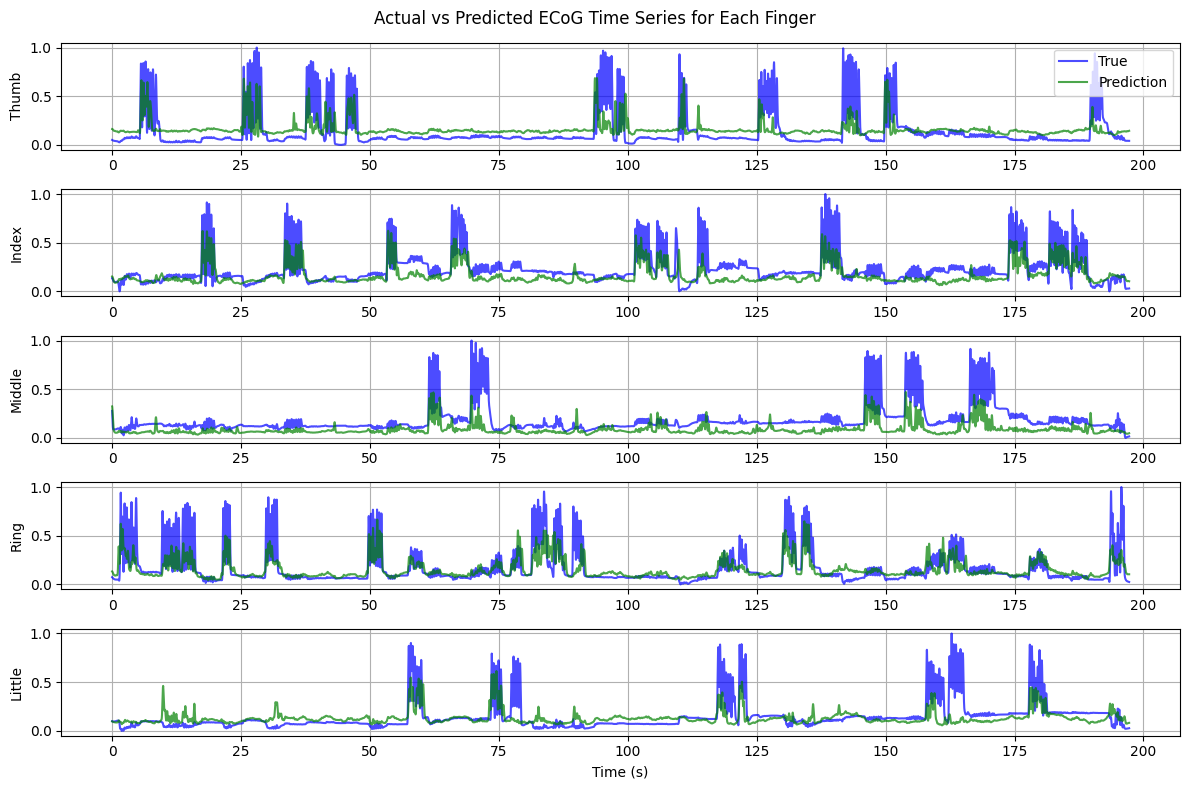

In [20]:
# Plot the actual and predicted ECoG signals for each finger
finger_labels = ['Thumb', 'Index', 'Middle', 'Ring', 'Little']
time_axis = np.arange(actuals.shape[0]) / SAMPLE_RATE # Time axis in seconds
plot_fingerwise_timeseries(actuals, predictions, time_axis=time_axis, finger_labels=finger_labels, sample=128)

/var/folders/0_/zdf3xmtj41l1qzfqgyfcbzcm0000gn/T/ipykernel_19220/3123457677.py:53: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/zaynesiew/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


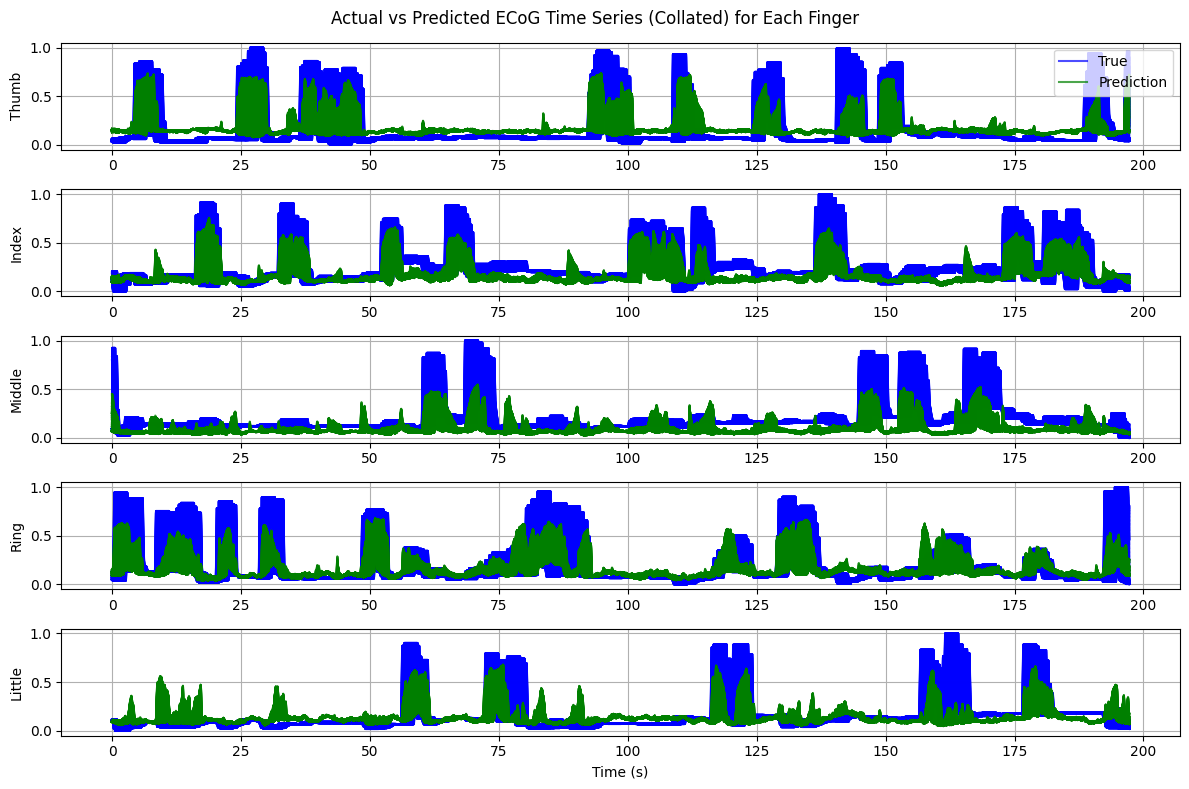

In [21]:
# Plot all samples, overlapping
plot_fingerwise_timeseries(actuals, predictions, time_axis=time_axis, finger_labels=finger_labels)